# Parameterisation for submesoscale vertical buoyancy flux : PK

__author__ : Aurélie Albert & Julien Le Sommer (MEOM, IGE)

__contributing author__ : Adekunle Ajayi (MEOM, IGE)

__context__ : 22-GLO-HR project : Lot 1 - Ocean Modelling

__date__ : 7 March 2018

__purpose__ : Metric for net release of available potential energy (PK) in NATL60-CJM165 simulation

__detailed description__ : 

To quantify the net release of available potential energy,
PK in a region, we integrate w’b’ over the mixed layer depth.

$$\mathcal PK = \frac{1}{h}\int^{-h}_{0} \langle w^{'} b^{'}\rangle_{xy} dz.$$


In the equation above, h represents the mixed layer depth, <>xy the horizontal averaging over region respectively. Prime represents the sub-mesoscale component of the flow.

__practical steps__ :

  * Input data are NATL60-CJM165 daily outputs of temperature, salinity  and vertical velocities for two whole month (March 2013 and September 2013)
  * step 1. : The daily mixed layer depth is computed from 3D T and S fields with cdfmxl cdftool : https://github.com/meom-group/CDFTOOLS : the computation is done on occigen servers
  * step 2. : 3D T and S fields are spatially filtered to keep the fine scales with the Lanczos2DHighPassFilter.py script written in the framework of the Vorticity Variance metric (see https://gitlab.com/meom-group-private/cmems-22-glo-hr-codes/tree/master/Task1-fine-scale-metrics/Vorticity-variance) : the computation is done on occigen servers
  * step 3. : The buoyancy is computed from small scale 3D fields of temperature and salinty with cdfbuoy cdftool : the computation is done on occigen servers   
  * step 4. : 10°x10° boxes already defined in the framework of the Kinetic energy wavenumber spectra are implemented (see https://gitlab.com/meom-group-private/cmems-22-glo-hr-codes/blob/master/Task1-fine-scale-metrics/Wavenumber-spectrum/cmems-glo-hr_demo-fine-scale-metrics_02_kinetic-energy-wavenumber-spectra.ipynb)
  * step 5. : The profile of the product of the mixed layer depth and the buoyancy is averaged inside each box.
  * step 6. : Plots of the monthly averaged profiles are produced for each box
  
__external libraries needed to run this script__ : 

 * Definition of 10°x10° for NATL60 grid :natl60_10_by_10_boxes.py
 * Tools for plot in boxes : plot_box
 
__licence__ : This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.

In [1]:
import sys
import glob
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy.ma as ma

%matplotlib inline
%autosave 60

Autosaving every 60 seconds


In [2]:
sys.path.insert(0,'/home/albert/lib/python/AJ-spectre/')
from natl60_10_by_10_boxes import boxes
import plot_box as pb

In [23]:
database = '/media/extra/DATA/NATL60/NATL60-CJM165-S/'
march_buoyfiles = sorted(glob.glob(database + 'filt-3D/NATL60-CJM165_y2013m03d*.1d_buoyancy_filt-n80-f0.0125.nc'))
march_wfiles = sorted(glob.glob(database + 'filt-3D/NATL60-CJM165_y2013m03d*.1d_vovecrtz_filt-n80-f0.0125.nc'))
march_mldfiles = sorted(glob.glob(database + 'MXL/NATL60-CJM165_y2013m03d*.1d_somxl010.nc'))
sept_buoyfiles = sorted(glob.glob(database + 'filt-3D/NATL60-CJM165_y2013m09d*.1d_buoyancy_filt-n80-f0.0125.nc'))
sept_wfiles = sorted(glob.glob(database + 'filt-3D/NATL60-CJM165_y2013m09d*.1d_vovecrtz_filt-n80-f0.0125.nc'))
sept_mldfiles = sorted(glob.glob(database + 'MXL/NATL60-CJM165_y2013m09d*.1d_somxl010.nc'))
maskfile= '/media/extra/DATA/NATL60/NATL60-I/NATL60_v4.1_cdf_byte_mask.nc'

In [24]:
print sept_buoyfiles

[]


In [4]:
dep=xr.open_dataset(march_buoyfiles[0])['deptht']

In [5]:
def get_values_in_box(box,data):
    jmin,jmax = box.jmin,box.jmax
    imin,imax = box.imin,box.imax
    values = data[:,:,jmin:jmax+1,imin:imax+1]
    return values


In [6]:
def Estimate_wb(box,buoy,w,tmask,wmask):
    buoy_box = get_values_in_box(box,buoy)
    w_box = get_values_in_box(box,w)  
    
    tmask_box = get_values_in_box(box,tmask)
    wmask_box = get_values_in_box(box,wmask)
    
    if box.name == 'Box_14':
        tmask_box[:,117,820:850,470:500]=0
        tmask_box[:,129,485:510,360:400]=0
        
    if box.name == 'Box_12':
        tmask_box[:,49,950:965,10:140]=0
        
    if box.name == 'Box_11':
        tmask_box[:,54,200:225,40:60]=0
    
    buoy_box_mask=ma.masked_where(tmask_box == 0, buoy_box)
    w_box_mask=ma.masked_where(wmask_box == 0, w_box)
    
    avg_wb_box=np.ones(len(dep))
    
    for k in np.arange(len(dep)):
        avg_wb_box[k] = np.nanmean(buoy_box_mask[0,k,:,:]*w_box_mask[0,k,:,:])
    return avg_wb_box

In [9]:
def get_wb_in_boxes(buoyfiles,wfiles):
    global boxes
    _Ann_wb_arr = []
    for i in range(len(buoyfiles)): 
        print buoyfiles[i]
        buoy = xr.open_dataset(buoyfiles[i])['sobuoy']
        w = xr.open_dataset(wfiles[i])['vovecrtz']
        tmask = xr.open_dataset(maskfile)['tmask']
        wmask = xr.open_dataset(maskfile)['fmask']
        _wb_arr=[]
        for box in boxes:
            wb = Estimate_wb(box,buoy,w,tmask,wmask)
            _wb_arr.append(wb)
        wb_arr = np.array(_wb_arr)
        _Ann_wb_arr.append(wb_arr)
    Ann_wb_arr = np.array(_Ann_wb_arr)
    return Ann_wb_arr

In [11]:
wb_boxes_march = get_wb_in_boxes(march_buoyfiles,march_wfiles)

/media/extra/DATA/NATL60/NATL60-CJM165-S/filt-3D/NATL60-CJM165_y2013m03d01.1d_buoyancy_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/filt-3D/NATL60-CJM165_y2013m03d02.1d_buoyancy_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/filt-3D/NATL60-CJM165_y2013m03d03.1d_buoyancy_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/filt-3D/NATL60-CJM165_y2013m03d04.1d_buoyancy_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/filt-3D/NATL60-CJM165_y2013m03d05.1d_buoyancy_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/filt-3D/NATL60-CJM165_y2013m03d06.1d_buoyancy_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/filt-3D/NATL60-CJM165_y2013m03d07.1d_buoyancy_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/filt-3D/NATL60-CJM165_y2013m03d08.1d_buoyancy_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/filt-3D/NATL60-CJM165_y2013m03d09.1d_buoyancy_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM16

In [12]:
def get_2Dvalues_in_box(box,data):
    jmin,jmax = box.jmin,box.jmax
    imin,imax = box.imin,box.imax
    values = data[:,jmin:jmax+1,imin:imax+1]
    return values


In [13]:
def Estimate_mld(box,mld):
    mld_box = get_2Dvalues_in_box(box,mld)
    avg_mld_box=np.nanmean(mld_box)
    return avg_mld_box

In [18]:
def get_mld_in_boxes(mldfiles):
    global boxes
    _Ann_mld_arr = []
    for i in range(len(mldfiles)): 
        print mldfiles[i]
        mld = xr.open_dataset(mldfiles[i])['somxl010']
        _mld_arr=[]
        for box in boxes:
            mldb = Estimate_mld(box,mld)
            _mld_arr.append(mldb)
        mld_arr = np.array(_mld_arr)
        _Ann_mld_arr.append(mld_arr)
    Ann_mld_arr = np.array(_Ann_mld_arr)
    return Ann_mld_arr

In [19]:
mld_boxes_march = get_mld_in_boxes(march_mldfiles)

/media/extra/DATA/NATL60/NATL60-CJM165-S/MXL/NATL60-CJM165_y2013m03d01.1d_somxl010.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/MXL/NATL60-CJM165_y2013m03d02.1d_somxl010.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/MXL/NATL60-CJM165_y2013m03d03.1d_somxl010.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/MXL/NATL60-CJM165_y2013m03d04.1d_somxl010.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/MXL/NATL60-CJM165_y2013m03d05.1d_somxl010.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/MXL/NATL60-CJM165_y2013m03d06.1d_somxl010.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/MXL/NATL60-CJM165_y2013m03d07.1d_somxl010.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/MXL/NATL60-CJM165_y2013m03d08.1d_somxl010.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/MXL/NATL60-CJM165_y2013m03d09.1d_somxl010.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/MXL/NATL60-CJM165_y2013m03d10.1d_somxl010.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/MXL/NATL60-CJM165_y2013m03d11.1d_somxl010.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/MXL/NATL60-CJ

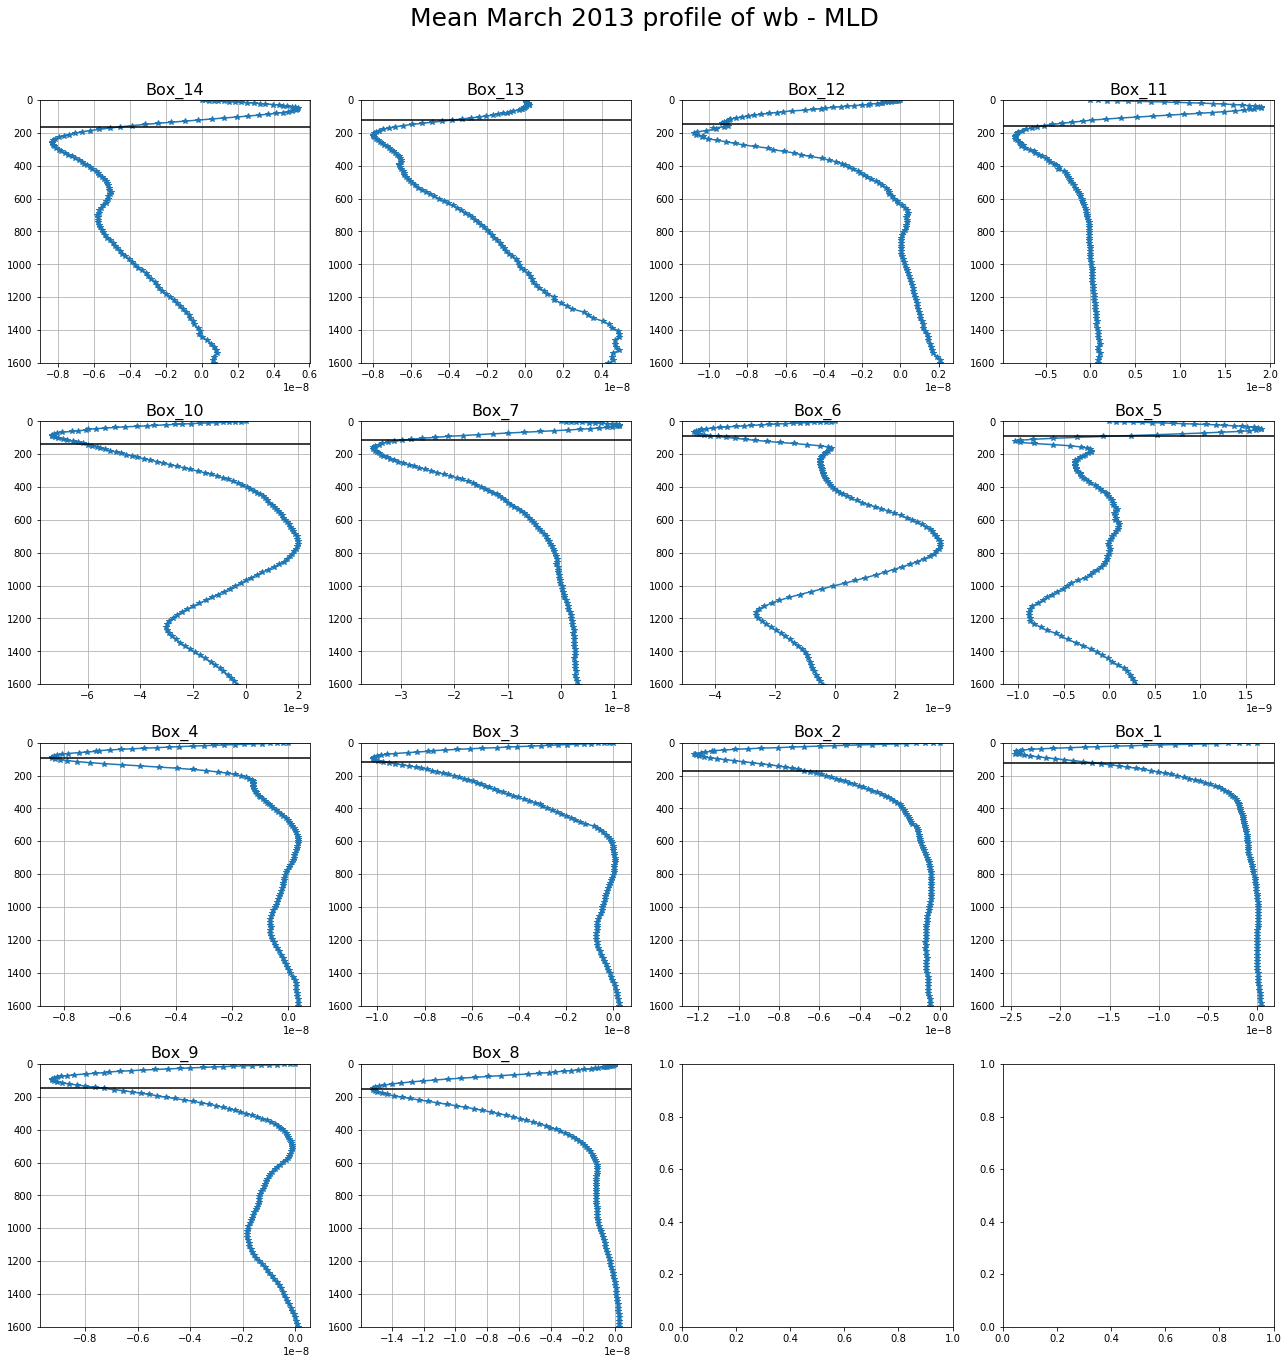

In [20]:
fig, axs = plt.subplots(4,4, figsize=(18, 18))
axs = axs.ravel()
title = 'Mean March 2013 profile of wb - MLD'
plt.suptitle(title,size = 25,y=1.05)
i = 0
for k,box in enumerate(boxes):
    axs[i].plot(np.nanmean(wb_boxes_march[:,k,:],0),dep,'C0*-')
    axs[i].set_title(box.name,size=16)
    axs[i].grid(True)
    axs[i].set_ylim(1600,0)
    axs[i].axhline(y=np.nanmean(mld_boxes_march[:,k]),color='k')
    i = i + 1
    fig.tight_layout()
    
plt.savefig("NATL60_wb_profiles_march13.png")

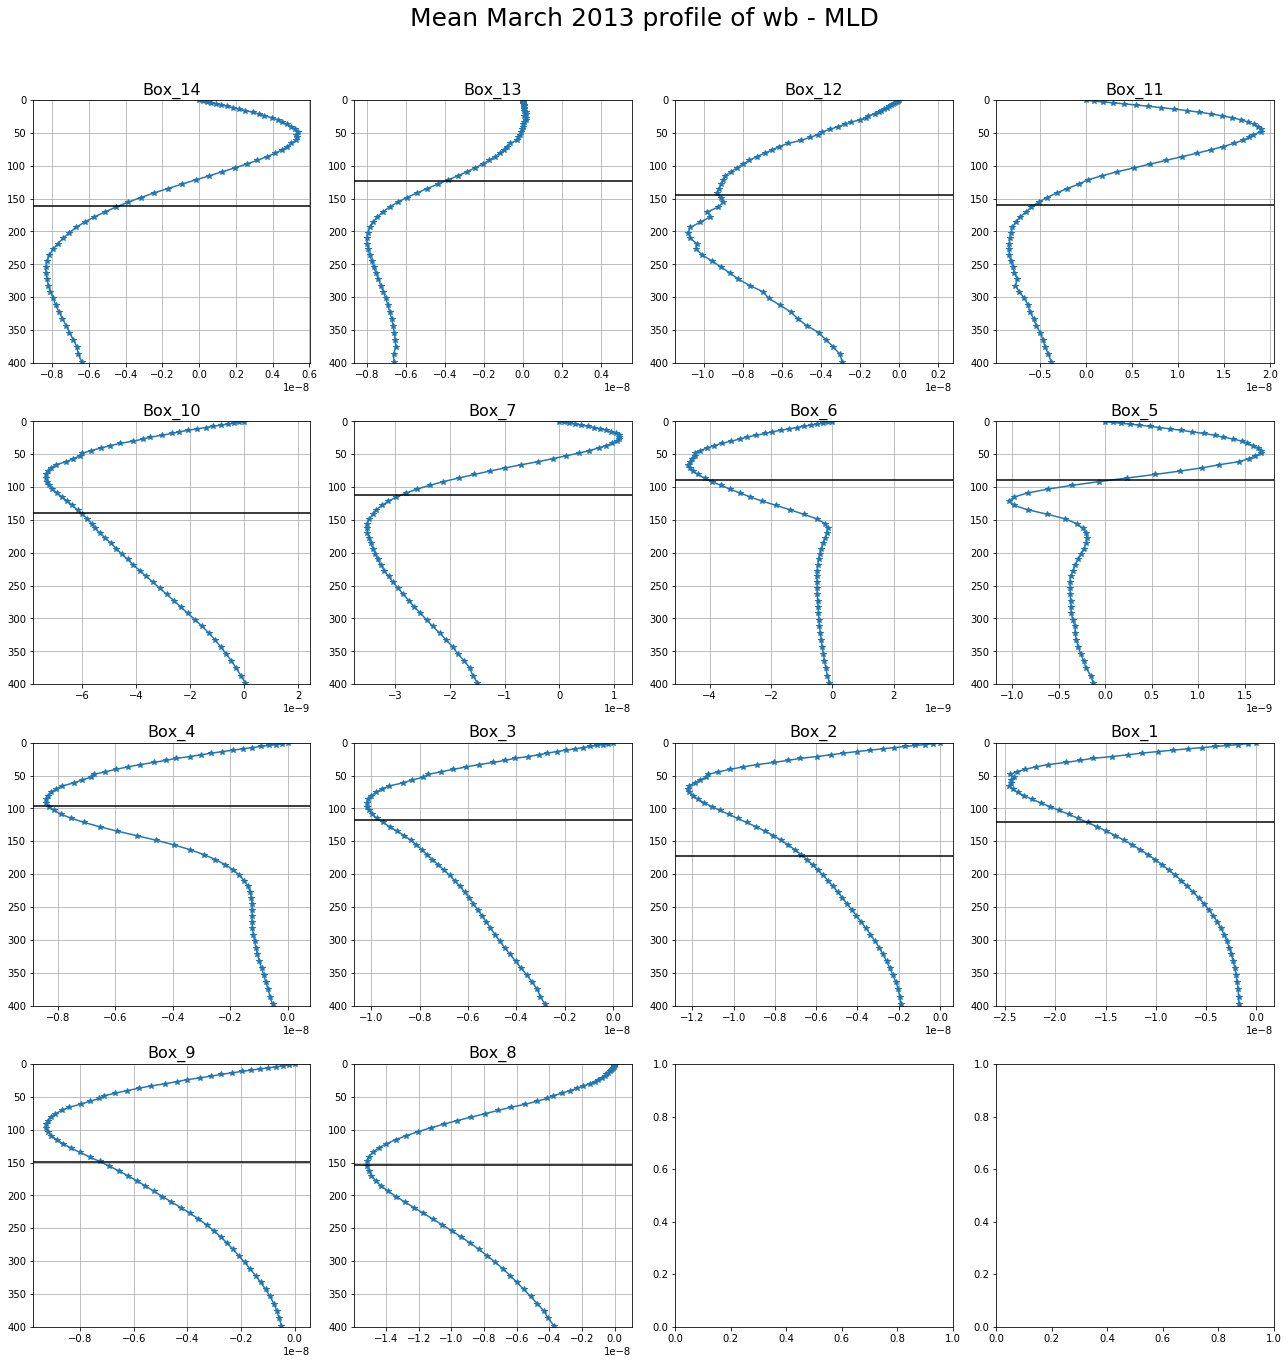

In [21]:
fig, axs = plt.subplots(4,4, figsize=(18, 18))
axs = axs.ravel()
title = 'Mean March 2013 profile of wb - MLD'
plt.suptitle(title,size = 25,y=1.05)
i = 0
for k,box in enumerate(boxes):
    axs[i].plot(np.nanmean(wb_boxes_march[:,k,:],0),dep,'C0*-')
    axs[i].set_title(box.name,size=16)
    axs[i].grid(True)
    axs[i].set_ylim(400,0)
    axs[i].axhline(y=np.nanmean(mld_boxes_march[:,k]),color='k')
    i = i + 1
    fig.tight_layout()
    
plt.savefig("NATL60_wb_profiles_march13_400m.png")

In [27]:
wb_boxes_march.shape

(31, 14, 139)

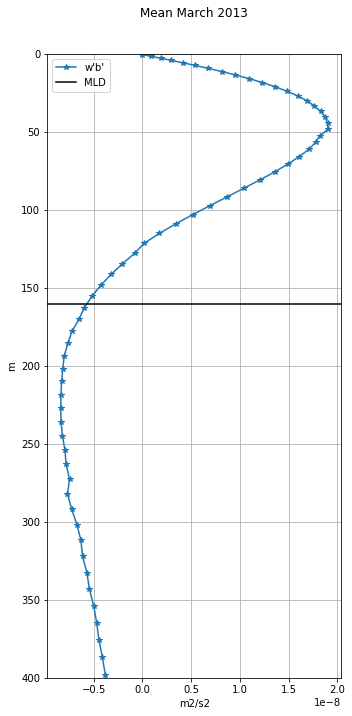

In [47]:
fig, axs = plt.subplots(1,1, figsize=(5, 10))

title = 'Mean March 2013'
plt.title(title,size = 12,y=1.05)
i = 0
axs.plot(np.nanmean(wb_boxes_march[:,3,:],0),dep,'C0*-',label='w\'b\'')
axs.grid(True)
axs.set_ylim(400,0)
axs.axhline(y=np.nanmean(mld_boxes_march[:,3]),color='k',label='MLD')
plt.xlabel('m2/s2')
plt.ylabel('m')
plt.legend()
fig.tight_layout()
    
plt.savefig("NATL60_box11_wb_profiles_march13_400m.png")